In [21]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F
import torch

In [22]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print(device)

# Hyperparameter
lr =2e-4
BATCH_SIZE = 256
NUM_EPOCHS = 50

logging_interval = 50
# save_model = True

cuda:2


In [23]:
import os

In [24]:
trf = transforms.Compose([
  transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='.',
                                train=True,
                                transform=trf,
                                download=True)

test_dataset = datasets.MNIST(root='.',
                              train=False,
                              transform=trf)


In [25]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=2,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                      batch_size=BATCH_SIZE,
                      num_workers=2,
                      shuffle=False)

In [26]:
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

Training Set:

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


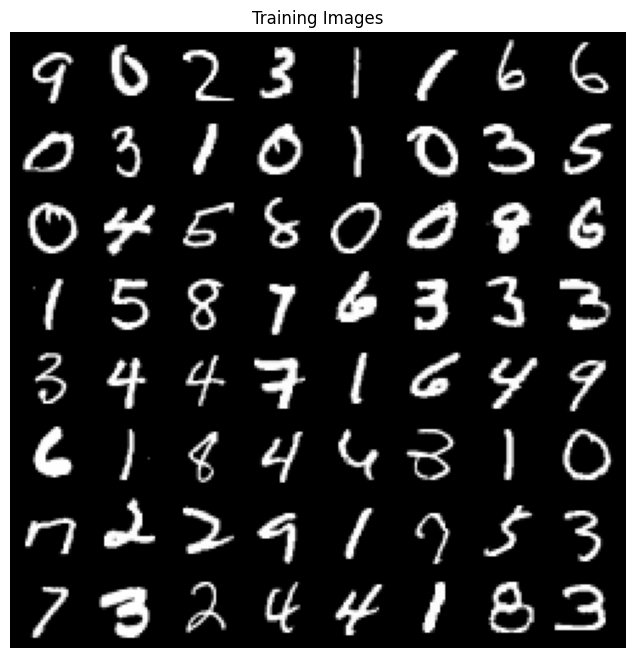

In [27]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(images[:64],
                        padding=2, normalize=True),
                        (1, 2, 0)))
plt.show()

In [7]:
## Utility function to Reshape and Trim the images

class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

## Define a model

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=1, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                #
                nn.Flatten(),
        )

        self.z_mean = torch.nn.Linear(3136, 2) # 7x7x64
        self.z_log_var = torch.nn.Linear(3136, 2)

        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 1, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    # Instead of sampling directly from N(z_mu, exp(z_log_var)), we sample from a standard normal ε ~ N(0, 1)
    # z=μ+σ⋅ϵ; σ=e^(0.5⋅logσ^2)
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z
    # Why reparameterize is necessary? - This allows backpropagation through stochastic sampling.

    # encoding_fn is used for visualizing our latent space      
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [9]:
model = VAE()
model.to(device)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1, inplace=True)
    (7): Dropout2d(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1, inplace=True)
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mean): Linear(in_features=3136, out_features=2, bias=True)
  (z_log_var): Linear(in_features=3136, out_features=2, bias=True)
  (decoder): Sequenti

In [10]:
# Total num. of parametes
num_params = sum(p.numel() for p in model.parameters())
# Total num. of "trainable" parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total num. of parametes: {num_params}')
print(f'Total num. of Trainable parametes: {num_trainable_params}')

Total num. of parametes: 170789
Total num. of Trainable parametes: 170789


In [11]:
loss_fn = F.mse_loss # evaluation metrics

In [12]:
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            _, _, _, logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Training loop

In [14]:
log_dict = {'train_combined_loss_per_batch': [],
            'train_combined_loss_per_epoch': [],
            'train_reconstruction_loss_per_batch': [],
            'train_kl_loss_per_batch': []}

skip_epoch_stats = False

start_time = time.time()
for epoch in range(NUM_EPOCHS):
  model.train()
  for batch_idx, (features, _) in enumerate(train_loader):

    features = features.to(device)

    # FORWARD AND BACK PROP
    encoded, z_mean, z_log_var, decoded = model(features)

    # total loss = reconstruction loss + KL divergence

    kl_div = -0.5 * torch.sum(1 + z_log_var
                              - z_mean**2
                              - torch.exp(z_log_var),
                              axis=1) # sum over latent dimension

    batchsize = kl_div.size(0)
    kl_div = kl_div.mean() # average over batch dimension

    pixelwise = loss_fn(decoded, features, reduction='none')
    pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
    pixelwise = pixelwise.mean() # average over batch dimension

    loss = pixelwise + kl_div

    optimizer.zero_grad()

    loss.backward()
    # UPDATE MODEL PARAMETERS
    optimizer.step()

    # LOGGING
    log_dict['train_combined_loss_per_batch'].append(loss.item())
    log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
    log_dict['train_kl_loss_per_batch'].append(kl_div.item())

    if not batch_idx % logging_interval:
        print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
              % (epoch+1, NUM_EPOCHS, batch_idx,
                  len(train_loader), loss))

  if not skip_epoch_stats:
      model.eval()

      with torch.set_grad_enabled(False):  # save memory during inference
          train_loss = compute_epoch_loss_autoencoder(
              model, train_loader, loss_fn, device)
          print('***Epoch: %03d/%03d | Loss: %.3f' % (
                epoch+1, NUM_EPOCHS, train_loss))
          log_dict['train_combined_loss_per_epoch'].append(train_loss.item())

  print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
# if save_model is not None:
#     torch.save({
#           'model_state_dict': model.state_dict(),
#           'optimizer_state_dict': optimizer_D.state_dict()
#           }, 'vae_mnist.pt')


/tmp/ipykernel_1818094/595489086.py:47: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'


Epoch: 001/050 | Batch 0000/0235 | Loss: 255.0624
Epoch: 001/050 | Batch 0050/0235 | Loss: 84.3248
Epoch: 001/050 | Batch 0100/0235 | Loss: 66.1473
Epoch: 001/050 | Batch 0150/0235 | Loss: 59.4644
Epoch: 001/050 | Batch 0200/0235 | Loss: 55.9294
***Epoch: 001/050 | Loss: 46.000
Time elapsed: 0.17 min
Epoch: 002/050 | Batch 0000/0235 | Loss: 54.0511
Epoch: 002/050 | Batch 0050/0235 | Loss: 51.4986
Epoch: 002/050 | Batch 0100/0235 | Loss: 49.5837
Epoch: 002/050 | Batch 0150/0235 | Loss: 49.8921
Epoch: 002/050 | Batch 0200/0235 | Loss: 47.7225
***Epoch: 002/050 | Loss: 42.605
Time elapsed: 0.33 min
Epoch: 003/050 | Batch 0000/0235 | Loss: 49.0769
Epoch: 003/050 | Batch 0050/0235 | Loss: 48.0767
Epoch: 003/050 | Batch 0100/0235 | Loss: 48.2691
Epoch: 003/050 | Batch 0150/0235 | Loss: 47.5492
Epoch: 003/050 | Batch 0200/0235 | Loss: 46.7642
***Epoch: 003/050 | Loss: 41.028
Time elapsed: 0.49 min
Epoch: 004/050 | Batch 0000/0235 | Loss: 47.3210
Epoch: 004/050 | Batch 0050/0235 | Loss: 46.226

## Plot loss

In [15]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

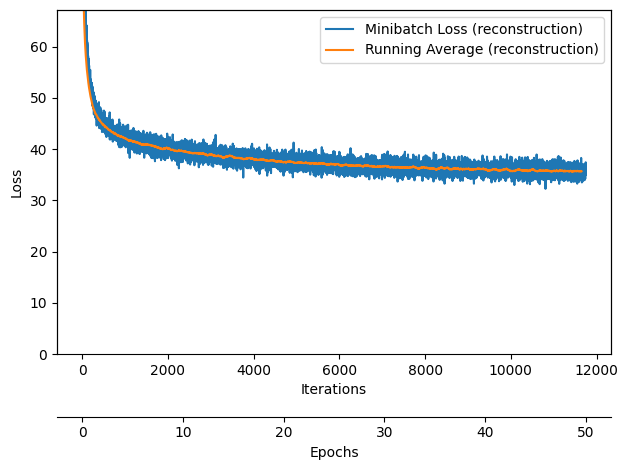

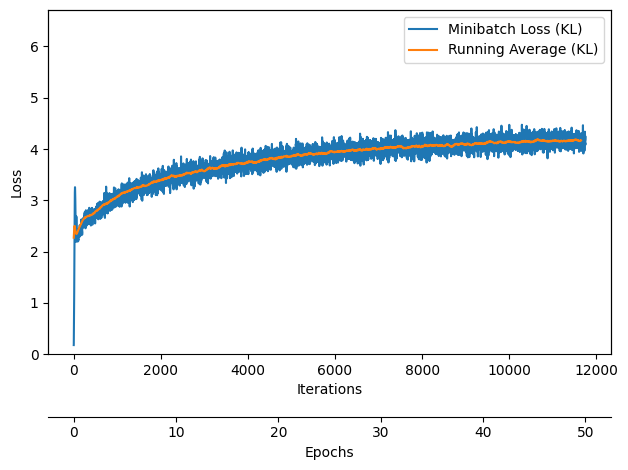

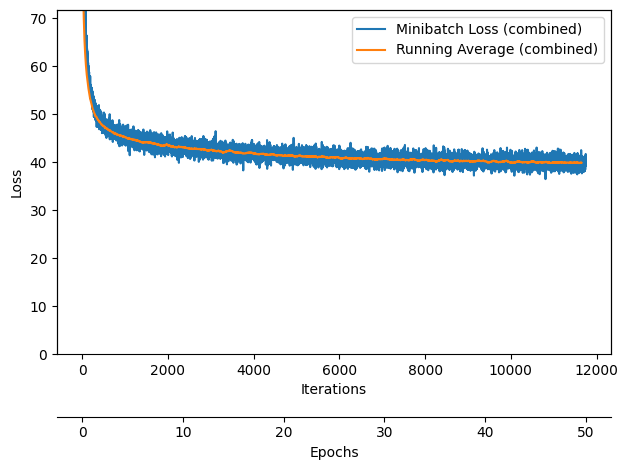

In [16]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

In [17]:
def plot_generated_images(data_loader, model, device,
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15):

  fig, axes = plt.subplots(nrows=2, ncols=n_images,
                            sharex=True, sharey=True, figsize=figsize)

  for batch_idx, (features, _) in enumerate(data_loader):

    features = features.to(device)

    color_channels = features.shape[1]
    image_height = features.shape[2]
    image_width = features.shape[3]

    with torch.no_grad():
        encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]

    orig_images = features[:n_images]
    break

  for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
      curr_img = img[i].detach().to(torch.device('cpu'))
      if unnormalizer is not None:
        curr_img = unnormalizer(curr_img)

      if color_channels > 1:
        curr_img = np.transpose(curr_img, (1, 2, 0))
        ax[i].imshow(curr_img)
      else:
        ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')


def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn, device):
  d = {i:[] for i in range(num_classes)}

  with torch.no_grad():
    for i, (features, targets) in enumerate(data_loader):
      features = features.to(device)
      targets = targets.to(device)

      embedding = encoding_fn(features)

      for i in range(num_classes):
        if i in targets:
          mask = targets == i
          d[i].append(embedding[mask].to('cpu').numpy())

  colors = list(mcolors.TABLEAU_COLORS.items())
  for i in range(num_classes):
    d[i] = np.concatenate(d[i])
    plt.scatter(
        d[i][:, 0], d[i][:, 1],
        color=colors[i][1],
        label=f'{i}',
        alpha=0.5)

  plt.legend()


def plot_images_sampled_from_vae(model, device, latent_size, unnormalizer=None, num_images=10):

  with torch.no_grad():
    ##########################
    ### RANDOM SAMPLE
    ##########################

    rand_features = torch.randn(num_images, latent_size).to(device)
    new_images = model.decoder(rand_features)
    color_channels = new_images.shape[1]
    image_height = new_images.shape[2]
    image_width = new_images.shape[3]

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:num_images]

    for ax, img in zip(axes, decoded_images):
      curr_img = img.detach().to(torch.device('cpu'))
      if unnormalizer is not None:
        curr_img = unnormalizer(curr_img)

      if color_channels > 1:
        curr_img = np.transpose(curr_img, (1, 2, 0))
        ax.imshow(curr_img)
      else:
        ax.imshow(curr_img.view((image_height, image_width)), cmap='binary')


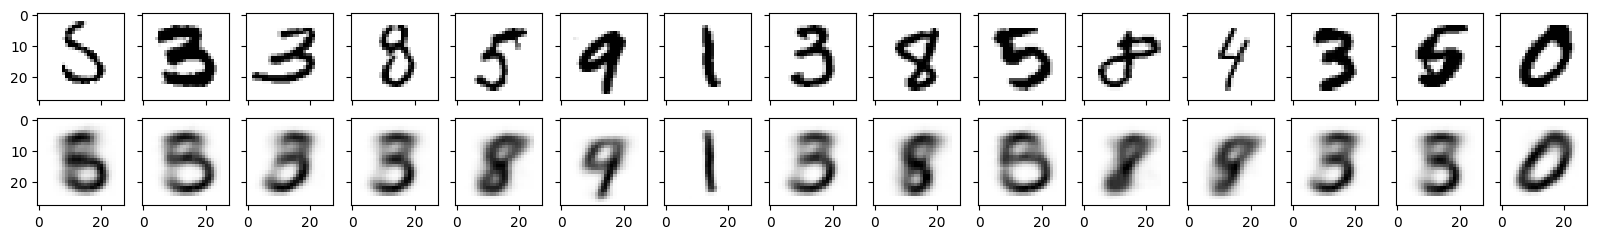

In [18]:
plot_generated_images(data_loader=train_loader, model=model, device=device)

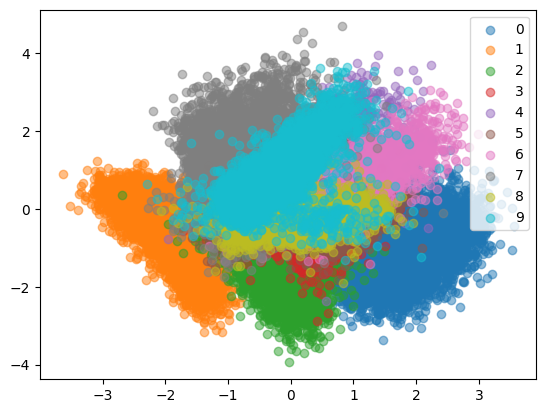

In [19]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn,
    device=device)

plt.legend()
plt.show()

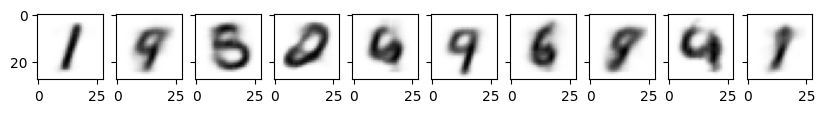

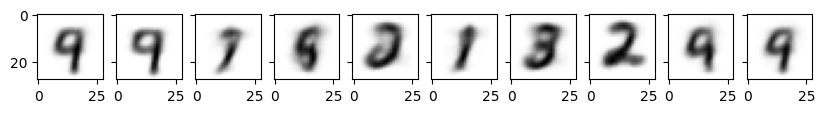

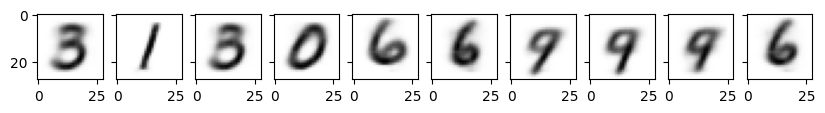

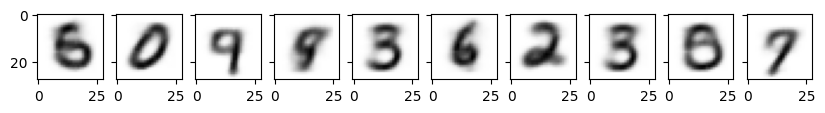

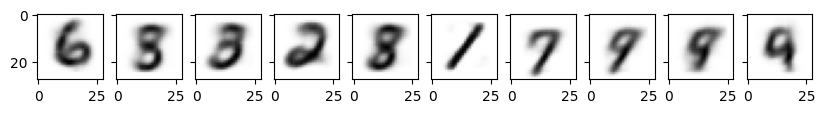

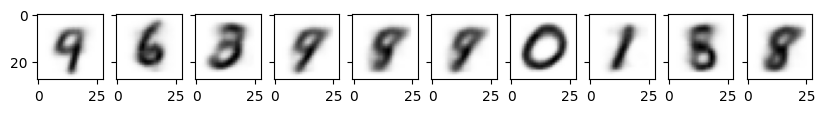

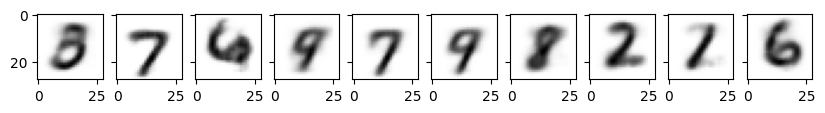

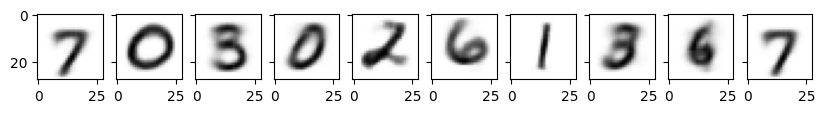

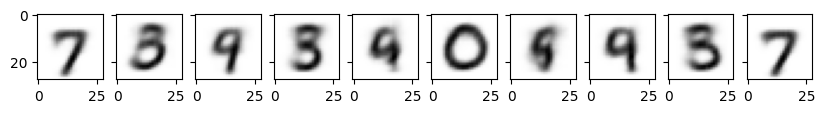

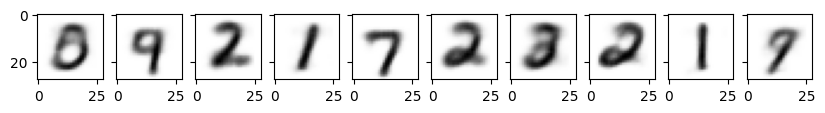

In [20]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=device, latent_size=2)
    plt.show()